### Create MapBox tiles (mbtiles) 
Based on [this Sci-team notebook](https://github.com/Vizzuality/sci_team_data_bank/blob/master/Projects/usa-resilience-opportunity-map/processing/create_MBTiles.ipynb)

If not installed, install tippecanoe in terminal with: $brew install tippecanoe

## python libraries

In [8]:
import pandas as pd 
import geopandas as gpd
import getpass
import requests
import shapely.wkb 
import subprocess

## Utils

In [9]:
def create_mbtiles(source_path, dest_path, layer_name, opts="-zg --drop-densest-as-needed --extend-zooms-if-still-dropping --force --read-parallel"):
    """
    Use tippecanoe to create a MBTILE at dest_path from source_path.
    layer_name is used for the name of the layer in the MBTILE.
    Regex file path (/*.geojson) is supported for source_path.
    """
    cmd = f"tippecanoe -o {dest_path} -l {layer_name} {opts} {source_path}"
    print(f"Processing: {cmd}")
    r = subprocess.call(cmd, shell=True)
    if r == 0:
        print("Task created")
    else:
        print("Task failed")
    print("Finished processing")

## Read data
The data includes the tourism regions and other polygon and point contextual data (airports, ski resorts, tourism centers, etc)
* All layers must be sjoined with the tourism-regions layer to make sure we can filter on the map  
* The names of the tourism regions are modified to match the syntax used in the API

### Tourism regions

In [10]:
region = gpd.read_file('../data/raw/ADM_TOURISM_REGIONS_SP.geojson')
#region

In [11]:
rename = {'Vancouver Island':'vancouver_island',
         'Vancouver, Coast and Mountains':'vancouver_coast_and_mountains',
         'Thompson Okanagan':'thompson_okanagan',
         'Kootenay Rockies':'kootenay_rockies',
         'Cariboo Chilcotin Coast':'cariboo_chilcotin_coast',
         'Northern British Columbia':'northern_british_columbia'}
region.replace({'TOURISM_REGION_NAME':rename}, inplace =True)

#Save first time
#region.to_file('../data/raw/ADM_TOURISM_REGIONS_SP_apiname.geojson', driver="GeoJSON")

### Contextual layers
For all layers: 
1. Join with tourism layer to be able to filter by tourism region on the platform map
2. Create mbtiles
3. Upload to TOTA Mapbox

+ Ski resorts
+ First Nations community locations
+ First Nations business list
+ Trails
+ Airports
+ [Wildlife habitats](#Wildlife-Layer) --> Needs extra processing step to split polygons

[Economic regions vs Tourism Regions](#Economig-regions)

In [60]:
# layers = {'ski_resorts': '../data/raw/GSR_SKI_RESORTS_SV.geojson',
#          'first_nations_communities':'../data/raw/FN_COMMUNITY_LOCATIONS_SP.geojson',
#          'first_nations_business':'../data/raw/GSR_INDIGENOUS_BUSINESSES_SV.geojson',
#          'wildlife_habitats':'../data/raw/WCP_WILDLIFE_HABITAT_AREA_POLY.geojson'}
layers = {'airports': '../data/raw/BCGW_7113060B_1627367952871_1544/GSR_AIRPORTS_SVW.geojson',
         'trails':'../data/raw/BCGW_7113060B_1627368738210_2232/FTEN_RECREATION_LINES_SVW.geojson'}

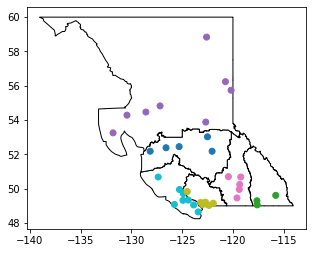

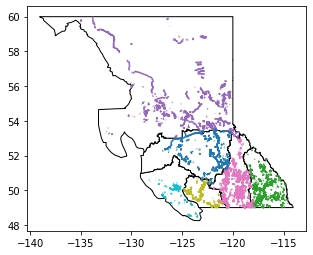

In [61]:
import matplotlib.pyplot as plt

region = gpd.read_file('../data/raw/ADM_TOURISM_REGIONS_SP_apiname.geojson')
for layer in layers.keys():
    gdf = gpd.read_file(layers[layer])
    if layer == 'airports':
        gdf = gdf[gdf['DESCRIPTION'] =='airport'] ### get only airports (exclude heliports and other airways)
    gdf_region = gpd.sjoin(gdf, region[['TOURISM_REGION_NAME','geometry']], how ='inner')
    gdf_region.to_file(f"../data/processed/{layers[layer].split('/')[4].split('.')[0]}"+"_region.geojson", driver="GeoJSON")
    
    fig, ax = plt.subplots(figsize =(5,5))
    region.plot(ax=ax, color='white', edgecolor='black')
    gdf_region.plot(ax=ax, column='TOURISM_REGION_NAME')

    plt.show()
    

In [56]:
gdf = gpd.read_file(layers['airports'])

In [59]:
gdf[gdf['DESCRIPTION'] =='airport']

,CUSTODIAN_ORG_DESCRIPTION,BUSINESS_CATEGORY_CLASS,BUSINESS_CATEGORY_DESCRIPTION,OCCUPANT_TYPE_DESCRIPTION,SOURCE_DATA_ID,SUPPLIED_SOURCE_ID_IND,AIRPORT_NAME,DESCRIPTION,PHYSICAL_ADDRESS,ALIAS_ADDRESS,...,MAX_RUNWAY_LENGTH,NUMBER_OF_RUNWAYS,OIL_AVAILABILITY_IND,RUNWAY_SURFACE,SEAPLANE_ACCESS_IND,TC_LID_CODE,SEQUENCE_ID,SE_ANNO_CAD_DATA,fme_feature_type,geometry
0,"Ministry of Forest, Lands and Natural Resource...",airTransportation,Air Transportation,BC Airports,455,N,Terrace (Northwest Regional) Airport,airport,"4401 Bristol Rd, Terrace, BC","4401 Bristol Rd, Terrace, BC",...,2285.39,2,Y,asphalt,N,None,578,None,WHSE_IMAGERY_AND_BASE_MAPS.GSR_AIRPORTS_SVW,POINT (-128.57833 54.46861)
9,"Ministry of Forest, Lands and Natural Resource...",airTransportation,Air Transportation,BC Airports,464,N,Victoria International Airport,airport,"1640 Electra Blvd, North Saanich, BC","1640 Electra Blvd, North Saanich, BC",...,2132.99,3,Y,asphalt,N,None,734,None,WHSE_IMAGERY_AND_BASE_MAPS.GSR_AIRPORTS_SVW,POINT (-123.42583 48.64694)
27,"Ministry of Forest, Lands and Natural Resource...",airTransportation,Air Transportation,BC Airports,482,N,Nanaimo Airport,airport,"3350 Spitfire Rd, Nanaimo, BC","3350 Spitfire Rd, Nanaimo, BC",...,2012.29,1,Y,asphalt,N,None,854,None,WHSE_IMAGERY_AND_BASE_MAPS.GSR_AIRPORTS_SVW,POINT (-123.87028 49.05222)
28,"Ministry of Forest, Lands and Natural Resource...",airTransportation,Air Transportation,BC Airports,483,N,Tofino/Long Beach Airport,airport,"Tofino, BC","Tofino, BC",...,1524.00,3,N,asphalt/concrete,N,None,642,None,WHSE_IMAGERY_AND_BASE_MAPS.GSR_AIRPORTS_SVW,POINT (-125.77250 49.08222)
29,"Ministry of Forest, Lands and Natural Resource...",airTransportation,Air Transportation,BC Airports,484,N,Abbotsford International Airport,airport,"30440 Liberator Ave, Abbotsford, BC","30440 Liberator Ave, Abbotsford, BC",...,2925.17,2,Y,asphalt/concrete,N,None,1036,None,WHSE_IMAGERY_AND_BASE_MAPS.GSR_AIRPORTS_SVW,POINT (-122.36056 49.02528)
32,"Ministry of Forest, Lands and Natural Resource...",airTransportation,Air Transportation,BC Airports,487,N,Boundary Bay Airport,airport,"7800 Alpha Way, Delta, BC","7800 Alpha Way, Delta, BC",...,1708.71,2,Y,asphalt,N,None,828,None,WHSE_IMAGERY_AND_BASE_MAPS.GSR_AIRPORTS_SVW,POINT (-123.00750 49.07389)
37,"Ministry of Forest, Lands and Natural Resource...",airTransportation,Air Transportation,BC Airports,492,N,Langley Regional Airport (Langley Airport),airport,"5385 216 St, Langley, BC","5385 216 St, Langley, BC",...,836.07,2,Y,asphalt,N,None,1320,None,WHSE_IMAGERY_AND_BASE_MAPS.GSR_AIRPORTS_SVW,POINT (-122.63056 49.10111)
51,"Ministry of Forest, Lands and Natural Resource...",airTransportation,Air Transportation,BC Airports,506,N,Chilliwack Airport,airport,"46244 Airport Rd, Chilliwack, BC","46244 Airport Rd, Chilliwack, BC",...,1214.93,1,N,asphalt,N,None,900,None,WHSE_IMAGERY_AND_BASE_MAPS.GSR_AIRPORTS_SVW,POINT (-121.93889 49.15278)
52,"Ministry of Forest, Lands and Natural Resource...",airTransportation,Air Transportation,BC Airports,507,N,Vancouver International Airport,airport,"3211 Grant McConachie Way, Richmond, BC","3211 Grant McConachie Way, Richmond, BC",...,3505.20,3,Y,asphalt/concrete,N,None,946,None,WHSE_IMAGERY_AND_BASE_MAPS.GSR_AIRPORTS_SVW,POINT (-123.18389 49.19472)
59,"Ministry of Forest, Lands and Natural Resource...",airTransportation,Air Transportation,BC Airports,514,N,Pitt Meadows Airport (Pitt Meadows Regional Ai...,airport,"18799 Airport Way, Pitt Meadows, BC","18799 Airport Way, Pitt Meadows, BC",...,1430.12,3,Y,asphalt,N,None,1290,None,WHSE_IMAGERY_AND_BASE_MAPS.GSR_AIRPORTS_SVW,POINT (-122.71000 49.21611)


### Wildlife Layer

In [30]:
## Wildlife layer needs extra step of dividing polygons first before spatial join
region = gpd.read_file('../data/raw/ADM_TOURISM_REGIONS_SP_apiname.geojson')
wildlife_raw= gpd.read_file('../data/raw/WCP_WILDLIFE_HABITAT_AREA_POLY.geojson')

In [ ]:
### Separate multipolygons into individual polygons to be able to cut by country
def divide_multipolygons(gdf):
    df = pd.DataFrame()
    for line in range(len(gdf)):
        if type(gdf.iloc[line]['geometry']) == shapely.geometry.polygon.Polygon:
            merge = gdf.iloc[[line],:]
            df = df.append(merge)  
        else:
            shapes = list(gdf.iloc[line]['geometry'])
            other_data = gdf.iloc[[line],gdf.columns != 'geometry']

            for i in range(len(shapes)):
                merge = pd.DataFrame(data=other_data)
                merge['geometry'] = shapes[i]
                df = df.append(merge)
    return df

In [44]:
#wildlife_split = divide_multipolygons(wildlife_raw)
#wsplit_region = gpd.sjoin(wildlife_split, region[['TOURISM_REGION_NAME','geometry']], how ='inner')
wsplit_region.to_file('../data/processed/WCP_WILDLIFE_HABITAT_AREA_POLY_region.geojson', driver="GeoJSON")

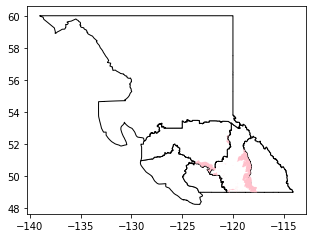

In [40]:
fig, ax = plt.subplots(figsize =(5,5))
region.plot(ax=ax, color='white', edgecolor='black')
wsplit_region[wsplit_region['TOURISM_REGION_NAME']=='thompson_okanagan'].plot(ax=ax, color='pink')
plt.show()

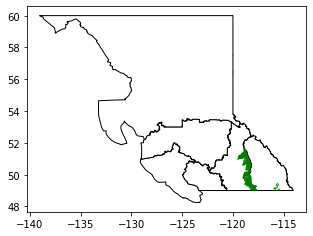

In [41]:
fig, ax = plt.subplots(figsize =(5,5))
region.plot(ax=ax, color='white', edgecolor='black')
wsplit_region[wsplit_region['TOURISM_REGION_NAME']=='kootenay_rockies'].plot(ax=ax, color='green')
plt.show()

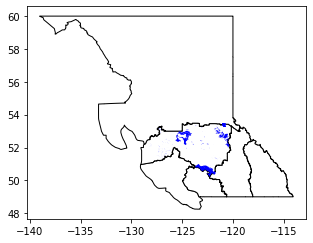

In [43]:
fig, ax = plt.subplots(figsize =(5,5))
region.plot(ax=ax, color='white', edgecolor='black')
wsplit_region[wsplit_region['TOURISM_REGION_NAME']=='cariboo_chilcotin_coast'].plot(ax=ax, color='blue')
plt.show()

In [39]:
wsplit_region = gpd.sjoin(wildlife_spli, region[['TOURISM_REGION_NAME','geometry']], how ='inner')

### Economic regions

In [43]:
region = gpd.read_file('../data/raw/ADM_TOURISM_REGIONS_SP_apiname.geojson')
dev= gpd.read_file('../data/raw/BCGW_7113060B_1628167339306_10764/CEN_ECONOMIC_REGIONS_SVW.geojson')

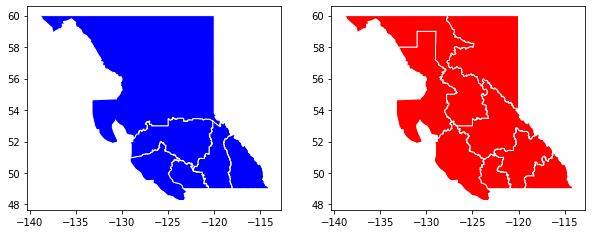

In [44]:
fig, axs = plt.subplots(nrows=1,ncols = 2,figsize =(10,5))
region.plot(ax=axs[0], color='blue', edgecolor='white')
dev.plot(ax=axs[1],color='red', edgecolor='white')

plt.show()

In [45]:
region.TOURISM_REGION_NAME.unique()

array(['vancouver_island', 'vancouver_coast_and_mountains',
       'thompson_okanagan', 'kootenay_rockies', 'cariboo_chilcotin_coast',
       'northern_british_columbia'], dtype=object)

In [46]:
dev.ECONOMIC_REGION_NAME.unique()

array(['Vancouver Island and Coast / Île de Vancouver et la côte',
       'Lower Mainland--Southwest / Lower Mainland--Sud-ouest',
       'Thompson--Okanagan', 'Kootenay', 'Cariboo',
       'North Coast / Côte-nord', 'Nechako', 'Northeast / Nord-est'],
      dtype=object)

In [47]:
correspondence = {'Vancouver Island and Coast / Île de Vancouver et la côte':'vancouver_island',
                 'Lower Mainland--Southwest / Lower Mainland--Sud-ouest':'vancouver_coast_and_mountains',
                 'Thompson--Okanagan':'thompson_okanagan',
                 'Kootenay':'kootenay_rockies',
                 'Cariboo':'cariboo_chilcotin_coast',
                 'North Coast / Côte-nord':'northern_british_columbia',
                 'Nechako':'northern_british_columbia',
                 'Northeast / Nord-est':'northern_british_columbia'}

In [48]:
dev['TOURISM_REGION_NAME']= dev['ECONOMIC_REGION_NAME'].map(correspondence)

In [51]:
dev.to_file(f"../data/processed/CEN_ECONOMIC_REGIONS_SVW_region.geojson", driver="GeoJSON")

# Create mbtiles

In [15]:
layer_name = "tourism_regions"
source_path = "../data/raw/ADM_TOURISM_REGIONS_SP_apiname.geojson"
dest_path = "../data/tourism_regions.mbtiles"
create_mbtiles(source_path, dest_path, layer_name, opts="-zg --drop-densest-as-needed --extend-zooms-if-still-dropping --force --read-parallel")

Processing: tippecanoe -o ../data/tourism_regions.mbtiles -l tourism_regions -zg --drop-densest-as-needed --extend-zooms-if-still-dropping --force --read-parallel ../data/ADM_TOURISM_REGIONS_SP_newname.geojson
Task created
Finished processing


In [16]:
layer_name = "ski_resorts"
source_path = "../data/processed/GSR_SKI_RESORTS_SV_region.geojson"
dest_path = "../data/processed/ski_resorts.mbtiles"
create_mbtiles(source_path, dest_path, layer_name, opts="-zg --drop-densest-as-needed --extend-zooms-if-still-dropping --force --read-parallel")

Processing: tippecanoe -o ../data/ski_resorts.mbtiles -l ski_resorts -zg --drop-densest-as-needed --extend-zooms-if-still-dropping --force --read-parallel ../data/GSR_SKI_RESORTS_SV_region.geojson
Task created
Finished processing


In [48]:
### First round
mbtiles= {'ski_resorts': {'source':'../data/processed/GSR_SKI_RESORTS_SV_region.geojson', 
                                   'dest':'../data/processed/ski_resorts.mbtiles'},
         'first_nations_communities':{'source':'../data/processed/FN_COMMUNITY_LOCATIONS_SP_region.geojson',
                                      'dest':'../data/processed/first_nations_communities.mbtiles'},
         'first_nations_business':{'source':'../data/processed/GSR_INDIGENOUS_BUSINESSES_SV_region.geojson',
                                   'dest':'../data/processed/first_nations_business.mbtiles'},
         'wildlife_habitats':{'source':'../data/processed/WCP_WILDLIFE_HABITAT_AREA_POLY_region.geojson',
                             'dest':'../data/processed/wildlife_habitats.mbtiles'}}

In [63]:
# Second round
mbtiles= {'airports': {'source':'../data/processed/GSR_AIRPORTS_SVW_region.geojson', 
                                   'dest':'../data/processed/airports.mbtiles'},
         'dev_region':{'source':'../data/processed/CEN_ECONOMIC_REGIONS_SVW_region.geojson',
                                      'dest':'../data/processed/economic_development_regions.mbtiles'},
         'trails':{'source':'../data/processed/FTEN_RECREATION_LINES_SVW_region.geojson',
                                   'dest':'../data/processed/trails.mbtiles'}}

In [64]:
mbtiles['airports']['source']

'../data/processed/GSR_AIRPORTS_SVW_region.geojson'

In [65]:
for layer in mbtiles.keys():
    layer_name = layer
    source_path = mbtiles[layer]['source']
    dest_path = mbtiles[layer]['dest']
    create_mbtiles(source_path, dest_path, layer_name, opts="-zg --drop-densest-as-needed --extend-zooms-if-still-dropping --force --read-parallel")
    

Processing: tippecanoe -o ../data/processed/airports.mbtiles -l airports -zg --drop-densest-as-needed --extend-zooms-if-still-dropping --force --read-parallel ../data/processed/GSR_AIRPORTS_SVW_region.geojson
Task created
Finished processing
Processing: tippecanoe -o ../data/processed/economic_development_regions.mbtiles -l dev_region -zg --drop-densest-as-needed --extend-zooms-if-still-dropping --force --read-parallel ../data/processed/CEN_ECONOMIC_REGIONS_SVW_region.geojson
Task created
Finished processing
Processing: tippecanoe -o ../data/processed/trails.mbtiles -l trails -zg --drop-densest-as-needed --extend-zooms-if-still-dropping --force --read-parallel ../data/processed/FTEN_RECREATION_LINES_SVW_region.geojson
Task created
Finished processing


### Upload thorugh [Mapbox Studio]( https://studio.mapbox.com/tilesets/) or Mapbox API
